In [1]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid, save_image
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

from models import *
from utils import *

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


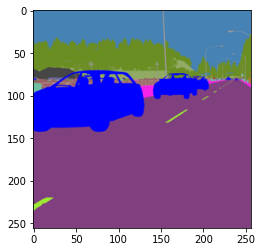

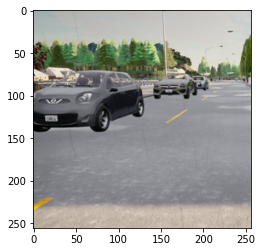

In [3]:
root_folder = "/home/gojkoc54/GOJKO/Faks/KV/data/pix2pix"
out_folder = "rgb_images"
in_folder = "sem_seg_images"
crop_size = (256, 256)
transform = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.Resize(crop_size),
    transforms.ToTensor()
])

dataset = Pix2PixDataset(root_folder, in_folder, out_folder, transform)

data = dataset[0]
print(data['in'].shape)
print(data['out'].shape)

plt.imshow(data['in'].permute(1, 2, 0))
plt.show()

plt.imshow(data['out'].permute(1, 2, 0))
plt.show()



In [2]:
params = {}
params['G_in_channels'] = 3 
params['G_hidden_channels'] = 64
params['G_out_channels'] = 3
params['G_depth'] = 4

params['D_in_channels'] = 3
params['D_hidden_channels'] = 64
params['D_depth'] = 3

p2p = Pix2Pix(params)
p2p.G.training

True

In [9]:
p2p.set_mode(G_mode='eval', D_mode='train')

print("G -- training = ", p2p.G.training)
print("G -- training = ", p2p.D.training)

G -- training =  False
G -- training =  True


In [2]:
lr = 0.0002
epochs = 100
batch_size = 4

display_step = 20

in_channels = 3
out_channels = 3
hidden_channels = 64
depth = 4

n_gpu = torch.cuda.device_count()
device = torch.device("cuda:0" if n_gpu else "cpu")

model = UNet(
    in_channels, out_channels, hidden_channels, depth
    ).to(device)

# criterion = nn.L1Loss()
criterion = nn.MSELoss()


optim = torch.optim.Adam(model.parameters(), lr=lr)

train_filepath = "../data/unet"
input_size = (256, 256)
loader, _ = load_datasets_UNet(
    train_filepath=train_filepath, val_filepath=None, 
    crop_size=1024, new_size=(256, 256), batch_size=batch_size
    )

In [9]:
# model
patch_gan

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [5]:
D = Discriminator(3).to(device)
D

Discriminator(
  (set_hidden_channels): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (set_output_channels): C

In [4]:
mean_loss = 0
counter = 0

for epoch in range(epochs):
    for data in loader:
        
        model.train()

        x = data[0].to(device)
        y = x.data

        optim.zero_grad()

        out = model(x)

        loss = criterion(out, y)
        loss.backward()
        optim.step()
        
        mean_loss = (mean_loss * counter + loss.item()) / (counter + 1)

        if counter % 10 == 0:
            print(f"Epoch {epoch} Iter {counter} LOSS: {loss.item()}")
        if counter % 50 == 0:
            print(f"Epoch {epoch} Iter {counter} MEAN LOSS: {mean_loss}")

        if counter % display_step == 0:
            # model.eval()
            in_out_tensor = torch.cat([x.detach(), out.detach()], axis=0)
            grid = make_grid(
                in_out_tensor.cpu(), nrow = data[0].shape[0]
                )
            save_image(grid, f"imgs/{counter}.png")
        
        counter += 1


Epoch 0 Iter 0 LOSS: 0.6222246885299683
Epoch 0 Iter 0 MEAN LOSS: 0.6222246885299683
Epoch 0 Iter 10 LOSS: 0.23369017243385315
Epoch 0 Iter 20 LOSS: 0.13128553330898285
Epoch 0 Iter 30 LOSS: 0.08453452587127686
Epoch 0 Iter 40 LOSS: 0.0869666039943695
Epoch 0 Iter 50 LOSS: 0.04071199148893356
Epoch 0 Iter 50 MEAN LOSS: 0.16160066579194637
Epoch 0 Iter 60 LOSS: 0.024754788726568222
Epoch 0 Iter 70 LOSS: 0.03322673961520195
Epoch 0 Iter 80 LOSS: 0.012611806392669678
Epoch 0 Iter 90 LOSS: 0.009473564103245735
Epoch 0 Iter 100 LOSS: 0.010616965591907501
Epoch 0 Iter 100 MEAN LOSS: 0.09231901971051602
Epoch 0 Iter 110 LOSS: 0.005720709916204214
Epoch 0 Iter 120 LOSS: 0.005231731571257114
Epoch 0 Iter 130 LOSS: 0.004924670793116093
Epoch 0 Iter 140 LOSS: 0.00597046036273241
Epoch 0 Iter 150 LOSS: 0.006686845328658819
Epoch 0 Iter 150 MEAN LOSS: 0.06431168236072789
Epoch 0 Iter 160 LOSS: 0.007255821488797665
Epoch 0 Iter 170 LOSS: 0.00850052572786808
Epoch 0 Iter 180 LOSS: 0.01857174187898636

KeyboardInterrupt: 